##  Custom regression models, with application to cure models

Like for univariate models, it is possible to create your own custom parametric survival models. Why might you want to do this? 

 - Create new / extend AFT models using known probability distributions
 - Create a piecewise model using domain knowledge about subjects
 - Iterate and fit a more accurate parametric model

*lifelines* has a very simple API to create custom parametric regression models. The author only needs to define the cumulative hazard function. For example, an Exponential regression model looks like:

$$ 
H(t, x) = \frac{t}{\lambda(x)}\\ \lambda(x) = \exp{(\vec{\beta} \cdot \vec{x}^{\,T})}
$$ 



Below are some example custom models.

In [1]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np
from lifelines.datasets import load_rossi

class ExponentialAFTFitter(ParametricRegressionFitter):
    
    # this is necessary, and should always be a non-empty list of strings. 
    _fitted_parameter_names = ['lambda_']
    
    def _cumulative_hazard(self, params, T, Xs):
        # params is a dictionary that maps unknown parameters to a numpy vector. 
        # Xs is a dictionary that maps unknown parameters to a numpy 2d array 
        lambda_ = np.exp(np.dot(Xs['lambda_'], params['lambda_']))
        return T / lambda_
    

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda_': rossi.columns
}

eaf = ExponentialAFTFitter().fit(rossi, 'week', 'arrest', regressors=regressors)
eaf.print_summary()

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1407: OptimizeWarning: Unknown solver options: exception_strategy
  options={"disp": show_progress, 'exception_strategy': 'damp_update'},


<lifelines.ExponentialAFTFitter: fitted with 432 observations, 318 censored>
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -686.37
  time fit was run = 2019-07-02 02:03:06 UTC

---
                   coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_ fin        0.37      1.44      0.19  1.92   0.06      4.18       -0.01        0.74
        age        0.06      1.06      0.02  2.55   0.01      6.52        0.01        0.10
        race      -0.30      0.74      0.31 -0.99   0.32      1.63       -0.91        0.30
        wexp       0.15      1.16      0.21  0.69   0.49      1.03       -0.27        0.56
        mar        0.43      1.53      0.38  1.12   0.26      1.93       -0.32        1.17
        paro       0.08      1.09      0.20  0.42   0.67      0.57       -0.30        0.47
        prio      -0.09      0.92      0.03 -3.03 <0.005      8.65       -0.14       -0.03
        intercept  4.05     57.44   

In [25]:
from lifelines.fitters import ParametricRegressionFitter
from autograd import numpy as np

class GompertzMakehamAFTFitter(ParametricRegressionFitter):
    
    _fitted_parameter_names = ['lambda_', 'alpha_', 'beta_']
    
    def _cumulative_hazard(self, params, T, Xs):
        lambda_ = np.exp(np.dot(Xs['lambda_'], params['lambda_']))
        beta_ =   np.exp(np.dot(Xs['beta_'], params['beta_']))
        alpha_ =  np.exp(np.dot(Xs['alpha_'], params['alpha_']))
        return lambda_* T + alpha_/beta_ * np.expm1(beta_ * T)
    

rossi = load_rossi()
rossi['intercept'] = 1.0

# the below variables maps dataframe columns to parameters
regressors = {
    'lambda_': ['intercept'],
    'alpha_': ['intercept'],
    'beta_': ['intercept']

}

gaf = GompertzMakehamAFTFitter(penalizer=10.).fit(rossi, 'week', 'arrest', regressors=regressors)
gaf.print_summary()

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1407: OptimizeWarning: Unknown solver options: exception_strategy
  options={"disp": show_progress},
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pil

/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_ra

/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g

/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_ra

/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_ra

/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_ra

      fun: nan
 hess_inv: array([[ 1.00000000e+00, -4.75457114e-29, -2.42456279e-27],
       [-4.75457114e-29,  9.99615595e-01, -1.96024763e-02],
       [-2.42456279e-27, -1.96024763e-02,  3.84404846e-04]])
      jac: array([nan, nan, nan])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 113
      nit: 2
     njev: 113
   status: 2
  success: False
        x: array([-4.69499382e+04, -2.27863393e+11,  4.46840445e+09])


/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:75: RuntimeWarning: invalid value encountered in multiply
  defvjp(anp.expm1,  lambda ans, x : lambda g: (ans + 1) * g)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:52: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.true_divide, lambda ans, x, y : unbroadcast_f(x, lambda g: g / y),
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:53: RuntimeWarning: invalid value encountered in multiply
  lambda ans, x, y : unbroadcast_f(y, lambda g: - g * x / y**2))
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/Users/camerondavidson-pilon/venvs/data/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_ra

ConvergenceError: Fitting did not converge. This could be a problem with your dataset:

0. Are there any lifelines warnings outputted during the `fit`?
1. Inspect your DataFrame: does everything look as expected?
2. Is there high-collinearity in the dataset? Try using the variance inflation factor (VIF) to find redundant variables.
3. Trying adding a small penalizer (or changing it, if already present). Example: `GompertzMakehamAFTFitter(penalizer=0.01).fit(...)`.
4. Are there any extreme outliers? Try modeling them or dropping them to see if it helps convergence.


### Cure models

Suppose in our population we have a subpopulation that will never experience the event of interest. Or, for some subjects the event will occur so far in the future that it's essentially at time infinity. In this case, the survival function for an individual should not asymptically approach zero, but _some positive value_. Models that describe this are sometimes called cure models (i.e. the subject is "cured" of death and hence no longer susceptible) or time-lagged conversion models. 

It would be nice to be able to use common survival models _and_ have some "cure" component. Let's suppose that for individuals that will experience the event of interest, their survival distrubtion is a Weibull, denoted $S_W(t)$. For a random selected individual in the population, thier survival curve, $S(t)$, is:

$$ 
\begin{align*}
S(t) = P(T > t) &= P(\text{cured}) P(T > t\;|\;\text{cured}) +  P(\text{not cured}) P(T > t\;|\;\text{not cured})  \\
      &= p + (1-p) S_W(t)
\end{align*}
$$

Even though it's in an unconvential form, we can still determine the cumulative hazard (which is the negative logarithm of the survival function):

$$ H(t) =  -\log{\left(p + (1-p) S_W(t)\right)} $$

In [19]:
from autograd.scipy.special import expit

class CureModel(ParametricRegressionFitter):

    _fitted_parameter_names = ["lambda_", "beta_", "rho_"]

    def _cumulative_hazard(self, params, T, Xs):
        c = expit(np.dot(Xs["beta_"], params["beta_"]))

        lambda_ = np.exp(np.dot(Xs["lambda_"], params["lambda_"]))
        rho_ = np.exp(np.dot(Xs["rho_"], params["rho_"]))
        sf = np.exp(-(T / lambda_) ** rho_)

        return -np.log((1 - c) + c * sf)


swf = CureModel(penalizer=.1)

rossi = load_rossi()
rossi["intercept"] = 1.0

covariates = {"lambda_": rossi.columns, "rho_": ["intercept"], "beta_": rossi.columns}

swf.fit(rossi, "week", event_col="arrest", regressors=covariates) 
swf.print_summary(2)

/Users/camerondavidson-pilon/code/lifelines/lifelines/fitters/__init__.py:1407: OptimizeWarning: Unknown solver options: exception_strategy
  options={"disp": show_progress},


<lifelines.CureModel: fitted with 432 observations, 318 censored>
         event col = 'arrest'
         penalizer = 0.01
number of subjects = 432
  number of events = 114
    log-likelihood = -697.06
  time fit was run = 2019-07-02 14:52:38 UTC

---
                   coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper 0.95
lambda_ fin        0.45      1.57      0.22  2.05   0.04      4.63        0.02        0.88
        age        0.10      1.10      0.02  5.84 <0.005     27.48        0.07        0.13
        race       0.46      1.59      0.28  1.68   0.09      3.42       -0.08        1.00
        wexp       0.60      1.83      0.22  2.74   0.01      7.33        0.17        1.04
        mar        0.56      1.76      0.30  1.90   0.06      4.12       -0.02        1.15
        paro      -0.03      0.97      0.22 -0.13   0.90      0.16       -0.47        0.41
        prio      -0.01      0.99      0.03 -0.43   0.67      0.58       -0.07        0.04
        intercept  1.

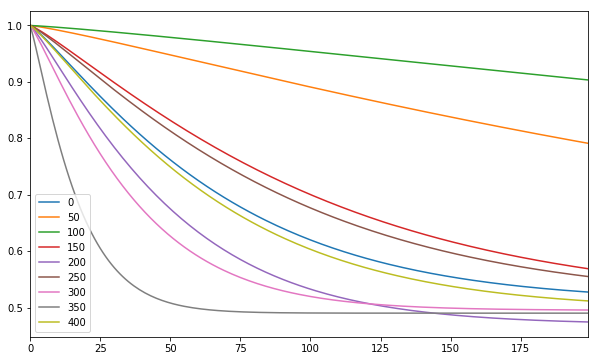

In [14]:
%matplotlib inline

swf.predict_survival_function(rossi.loc[::50], times=np.arange(0, 200)).plot(figsize=(10,6))